### <font color= 'white'> S&P 500 PostCovid *Optimizations & ML models*<font> 

##### [![S&P500-PostCovid_ML](https://img.shields.io/badge/Repository-S&P500--PostCovid--ML-020521?style=flat-square&logo=github&logoColor=white)](https://mango-dune-07a8b7110.1.azurestaticapps.net/?repo=EstebanMqz%2FSP500-Risk-Optimized-Portfolios-PostCovid-ML)

##### <font color= 'lightblue'> *Introduction.* <font>

Machine Learning has been around for decades but big data has substantially increased its value. <br>
Nowadays, predictive Machine Learning models are used in most industries including:
- Banking
- Insurance
- Retail
- Manufacturing
- Healthcare
- Government
- Education
- Agriculture
- Energy
- Transportation
- Telecommunications

Descriptive Statistics are made for datasets $X_i$ based on several metrics.<br>
$r_{t}$ $\&$ $\sigma_i$ are generally considered in most industries to integrate Prescriptive and Predictive models for businesses.<br>
In this case, based on certain constraints and objectives, we do so $\forall i \rightarrow X_P$ from $w$ optimizations.<br>

### <font color= 'lightblue'> 0. Requirements. <font>

##### <font color= 'lightblue'> 0.1 <u> Load Dependencies: </u><font>

In [2]:
import functions as fn
import data as dt
import visualizations as vs 

##### <font color= 'lightblue'> 0.2 <u> Install Libs. & Modules: </u><font>

<span style='color:green'> Project Users:</span> Install packages in `requirements.txt` file: <br>

In [2]:
dt.library_install("requirements.txt")

Requirements installed.

# -- -------------------------------------------------------------------------------------- -- # 
# -- project: S&P500-Risk-Optimized-Portfolios-PostCovid-ML                                 -- # 
# -- script: requirements.txt: txt file to download Python modules for execution            -- # 
# -- author: EstebanMqz                                                                     -- # 
# -- license: CC BY 3.0                                                                     -- # 
# -- repository: SP500-Risk-Optimized-Portfolios-PostCovid-ML/blob/main/requirements.txt    -- #                                  
# -- -------------------------------------------------------------------------------------- -- # 


numpy >= 1.23.5 
pandas >= 1.4.4 
matplotlib >= 3.5.3 
scipy >= 1.7.3 
sklearn >= 1.0.2 
jupyter >= 1.0.0 
yahoofinanicals >= 1.14 
tabulate >= 0.8.9 
IPython >= 8.12.0 



<span style='color:red'> Project Creators:</span> Create `requirements.txt` file:

<span style='color:lightyellow'> *Skip to 0.3 if you are not interested in contributing to the project.* <font>

In [4]:
docstring = """
# -- -------------------------------------------------------------------------------------- -- # 
# -- project: S&P500-Risk-Optimized-Portfolios-PostCovid-ML                                 -- # 
# -- script: requirements.txt: txt file to download Python modules for execution            -- # 
# -- author: EstebanMqz                                                                     -- # 
# -- license: CC BY 3.0                                                                     -- # 
# -- repository: SP500-Risk-Optimized-Portfolios-PostCovid-ML/blob/main/requirements.txt    -- #                                  
# -- -------------------------------------------------------------------------------------- -- # 
\n
"""

path = fn.get_requirements(docstring)

requirements.txt file created in local path: c:\Users\Esteban\Desktop\Projects\Github\Repos_To-do\Languages\Python\Fin_Sim\Projects\SP500-Risk-Optimized-Portfolios-ML\requirements.txt


##### <font color= 'lightblue'> 0.3 <u> Load Libraries & Modules </u><font>

In [3]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
plt.style.use("dark_background")
%matplotlib inline

import scipy
import scipy.stats as st
from scipy import optimize
from scipy.optimize import minimize

import sklearn
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV 
from sklearn import metrics

from yahoofinancials import YahooFinancials 
from tabulate import tabulate
import IPython.display as d

import datetime 
import time

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)

### <font color= 'lightblue'> 1. Data Extraction <font>

The following are the $S\&P500$ quotes symbols from *A-Z*:

<span style='color:lightyellow'> *Fetching a lot of data from Yahoo Finance by batches is required to avoid host disruptions (other sources could be used instead).* <font> &nbsp;

In [4]:
tickers=fn.SP500_tickers(50)
tickers[0][0:5], tickers[-1][0:5]

(['MMM', 'AOS', 'ABT', 'ABBV', 'ACN'], ['ZBH', 'ZION', 'ZTS'])

#### <font color= 'lightblue'> 1.1 <u> Fetching Data </u><font> </span>


<span style='color:lightyellow'> *Skip to 1.2 if you prefer using .csv creation date rather than execution's date.* <font> &nbsp; 


$6_Y$ of adj closes from the $S\&P$ $500$ quotes are fetched *(5min.)*.

In [ ]:
SP_Assets_f = pd.concat([dt.get_historical_price_data(tickers[i][j], 6) 
                         for i in range(0, len(tickers)) for j in range(0, len(tickers[i]))], axis=1)

In [8]:
SP_f = dt.get_historical_price_data('^GSPC', 6)
SP_f = SP_f[SP_f.index.isin(SP_Assets_f.index)]

Fetched data saved in `Assets_SP500.csv` $\&$ `SP500_index.csv` files in *subdirectory $\rightarrow$ `Data`*

In [17]:
SP_Assets_f.to_csv("Data/Assets_SP500.csv")   
SP_f.to_csv("Data/SP500.csv")

In [8]:
SP_Assets_f.head(8)

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
formatted_date,,,,,,,,,,,,,,,,,,,,,
2017-05-09,162.314407,49.483746,40.332916,50.679878,110.669518,52.981621,35.781647,135.600006,85.669312,135.433945,...,130.407761,169.407806,115.448715,37.699100,48.241051,62.149658,98.449997,109.968346,35.134594,57.183159
2017-05-10,161.232086,49.041607,40.179424,50.534348,110.788330,54.310524,35.722519,136.149994,85.272186,135.471054,...,130.270157,169.488968,115.271034,37.800148,47.487434,62.258118,98.870003,110.737549,35.143177,57.635395
2017-05-11,161.322250,48.825043,39.601570,50.013546,110.422691,54.077724,35.502892,136.289993,85.122169,135.276352,...,130.729004,169.335602,114.298531,38.019081,47.338577,62.484081,99.099998,112.155479,34.679638,57.462193
2017-05-12,161.174698,48.310715,39.691856,50.595631,110.568954,54.329922,35.443764,136.839996,85.748726,134.414383,...,130.600525,166.565811,117.159958,38.381180,47.431606,62.276211,99.639999,112.377899,34.465046,57.616135
2017-05-15,162.043839,48.725788,39.764084,51.062840,111.748161,54.717926,35.595814,137.600006,86.878273,135.183670,...,130.738159,163.642685,117.534012,38.574841,48.650433,62.565430,100.690002,113.369522,34.799816,57.731602
2017-05-16,162.273376,49.176960,39.448063,51.200691,112.561684,55.076832,35.663902,138.029999,86.763557,134.627563,...,130.903320,161.585648,119.609932,38.372742,48.166630,62.682938,100.500000,111.006310,34.971836,58.049126
2017-05-17,160.710373,48.211460,38.897301,50.067150,110.093636,52.603321,35.340462,134.330002,85.863426,133.988068,...,129.049667,157.679077,114.663223,38.406433,47.961926,62.511211,98.110001,109.097198,33.535458,57.471813
2017-05-18,161.040314,47.841503,38.807007,50.266289,110.057068,53.495720,35.161716,134.539993,86.790024,137.649124,...,128.333908,156.352844,114.476196,38.431686,47.896812,62.456974,98.110001,108.670891,34.042919,57.645012


In [11]:
SP_Assets_f.tail(8)

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
formatted_date,,,,,,,,,,,,,,,,,,,,,
2023-04-24,105.059998,68.613686,110.400002,164.080002,277.250000,86.089996,80.800003,377.339996,215.470001,126.830002,...,240.259995,673.438232,114.480003,71.029999,104.540001,138.899994,288.190002,138.139999,28.270000,176.350006
2023-04-25,104.370003,68.265244,109.970001,164.899994,270.700012,86.739998,75.900002,369.589996,211.690002,123.779999,...,239.589996,669.957947,111.629997,71.180000,102.919998,137.809998,284.100006,139.059998,26.730000,173.020004
2023-04-26,102.919998,67.200005,108.750000,161.800003,271.209991,76.809998,77.029999,363.059998,210.830002,122.330002,...,237.770004,657.981384,109.449997,69.680000,100.980003,138.009995,280.420013,139.080002,26.389999,172.940002
2023-04-27,105.330002,68.559998,109.500000,148.869995,275.450012,77.610001,78.010002,371.420013,216.160004,124.900002,...,225.809998,694.419556,110.220001,70.260002,103.830002,139.800003,284.119995,138.350006,26.580000,173.949997
2023-04-28,106.220001,68.290001,110.470001,151.119995,280.290009,77.709999,78.080002,377.559998,220.000000,125.529999,...,231.600006,693.631775,114.279999,69.910004,103.839996,140.580002,288.029999,138.440002,27.860001,175.779999
2023-05-01,105.849998,70.139999,111.110001,153.710007,279.420013,77.430000,77.800003,374.149994,221.119995,125.470001,...,233.240005,694.020691,115.599998,70.169998,104.500000,142.229996,287.450012,138.830002,26.820000,179.559998
2023-05-02,102.980003,69.779999,111.500000,151.619995,276.739990,76.000000,75.519997,368.660004,216.539993,124.120003,...,227.490005,686.890625,113.199997,69.099998,104.519997,142.899994,255.440002,143.009995,23.920000,176.899994
2023-05-03,102.830002,69.459999,111.760002,149.250000,275.179993,75.230003,75.019997,345.250000,215.979996,123.800003,...,226.149994,681.705078,109.330002,68.500000,104.150002,137.309998,258.500000,139.619995,22.660000,177.729996
2023-05-04,101.839996,69.190002,110.860001,147.360001,266.500000,74.589996,74.220001,335.829987,213.809998,120.239998,...,224.289993,665.640015,109.250000,69.110001,106.330002,136.320007,265.000000,136.630005,19.930000,178.470001


#### <font color= 'lightblue'> 1.2 <u> Reading data </u><font> </span>

Row simmetry is checked within data.

In [5]:
SP_r = pd.read_csv("Data/SP500.csv", index_col=0)
SP_Assets_r = pd.read_csv("Data/Assets_SP500.csv", index_col=0)

SP_r.shape, SP_Assets_r.shape

((1509, 1), (1509, 503))

### <font color= 'lightblue'> 2. Descriptive Analytics <font> </span>

##### <font color= 'lightblue'> 2.1 <u>$X_i$ metrics<u> <font>

Sharpe's Ratio is a metric that measures the units of risk *($\small \sigma$)* per unit of excess returns over a risk-free rate *($\small rf$)* :
+ $R_{Sharpe} = \frac{\mu_i - {rf}}{\sigma_i(r_t)}$.
<br>

Sortino's Ratio is a metric that measures the units of negative risks *[$\sigma_{i}\small(r_{t\leq 0})$]* per unit of excess returns over a risk-free rate *($\small rf$)* :
+ $R_{Sortino} = \frac{\mu_i - {rf}}{\sigma_{i}(r_{t\leq 0})}$ 

Selection based on *Sortino's Ratio top 25 from $S\&P500$* is made to avoid risks associated to a loss, for example.

|      |   $\mu_{i{yr}}$ |   $\sigma_{yr}$ |   $R_{Sharpe}$ |   $R_{Sortino}$ |
|:-----|----------------:|----------------:|---------------:|----------------:|
| LLY  |        0.439546 |        0.34004  |       1.24293  |         2.06968 |
| EQT  |        0.739324 |        0.650924 |       1.10984  |         1.9497  |
| PWR  |        0.549169 |        0.398733 |       1.3349   |         1.93998 |
| FSLR |        0.574193 |        0.530718 |       1.05007  |         1.65684 |
| NVDA |        0.603997 |        0.557493 |       1.0531   |         1.65645 |
| MRNA |        0.794179 |        0.798233 |       0.973749 |         1.62732 |
| MCK  |        0.334021 |        0.306705 |       1.03396  |         1.57559 |
| STLD |        0.553778 |        0.502902 |       1.06756  |         1.53834 |
| NUE  |        0.510443 |        0.462683 |       1.0667   |         1.53052 |
| ON   |        0.649095 |        0.616904 |       1.02479  |         1.51499 |
| CDNS |        0.424275 |        0.39579  |       1.02927  |         1.49501 |
| FCX  |        0.569215 |        0.581038 |       0.950565 |         1.45907 |
| CMG  |        0.383529 |        0.398468 |       0.920096 |         1.44333 |
| SNPS |        0.376237 |        0.381583 |       0.941702 |         1.40487 |
| ANET |        0.415803 |        0.428133 |       0.931728 |         1.39028 |
| TSCO |        0.373575 |        0.333879 |       1.06828  |         1.377   |
| GWW  |        0.334868 |        0.325289 |       0.977495 |         1.36794 |
| AAPL |        0.334813 |        0.355936 |       0.893174 |         1.29789 |
| DVN  |        0.665618 |        0.688414 |       0.942337 |         1.28089 |
| AZO  |        0.347964 |        0.316094 |       1.04736  |         1.23099 |
| ORLY |        0.335802 |        0.31142  |       1.02403  |         1.21046 |
| FTNT |        0.456049 |        0.483749 |       0.907804 |         1.20397 |
| GIS  |        0.236349 |        0.241936 |       0.907056 |         1.18754 |
| DE   |        0.347819 |        0.369404 |       0.89582  |         1.18613 |
| AJG  |        0.285816 |        0.292782 |       0.918486 |         1.10845 |

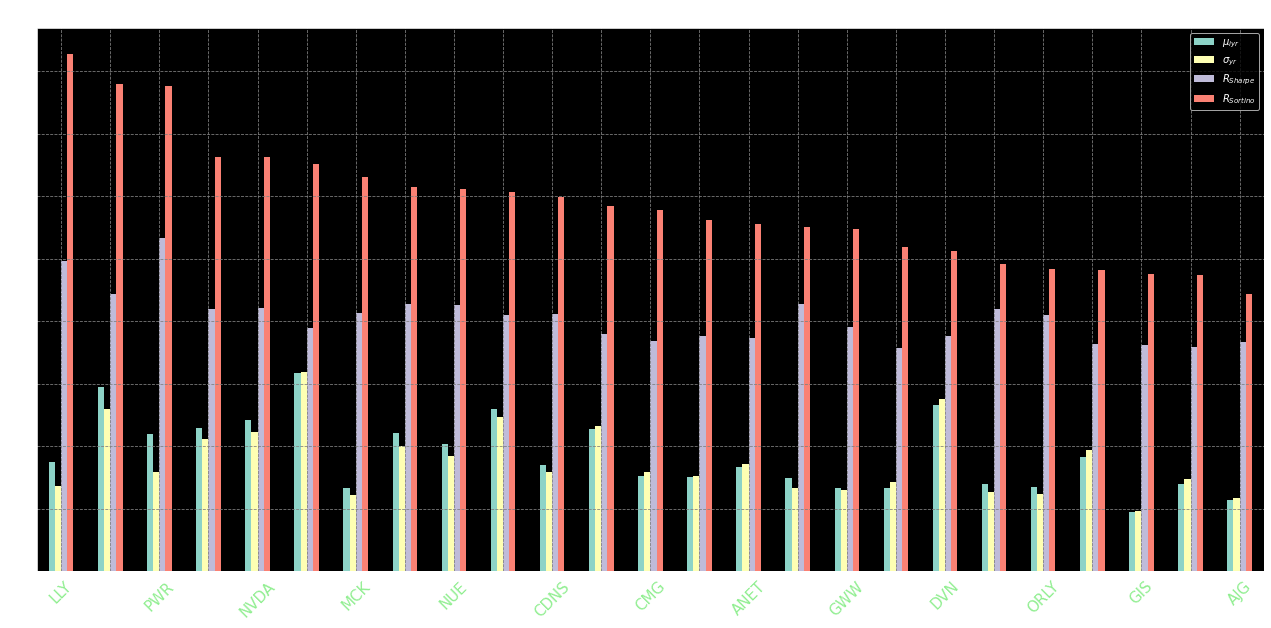

In [118]:
today = (datetime.date.today()).strftime("%Y-%m-%d")
Sortino25 = vs.selection_data(SP_Assets_r.loc["2020-03-02":today], 0.0169, "S&P 500 Metrics from 2020-03-02 to " +str(today), 25)

In [119]:
test = (SP_Assets_r.loc["2020-03-02":today][Sortino25[2].index].pct_change()).iloc[1:, :].dropna(axis = 1)
test.index = pd.to_datetime(test.index)
test.head()

,LLY,EQT,PWR,FSLR,NVDA,MRNA,MCK,STLD,NUE,ON,...,TSCO,GWW,AAPL,DVN,AZO,ORLY,FTNT,GIS,DE,AJG
formatted_date,,,,,,,,,,,,,,,,,,,,,
2020-03-03,-0.019046,0.011513,-0.006953,-0.016463,-0.038129,-0.065930,-0.017353,-0.023085,-0.019438,-0.042261,...,0.018146,-0.010454,-0.031759,-0.031882,-0.021187,-0.037580,-0.059673,0.004668,-0.037457,-0.027244
2020-03-04,0.077277,-0.006504,0.043568,0.028727,0.070029,-0.015048,0.030176,0.025881,0.031526,0.033094,...,0.034464,0.030820,0.046385,0.029766,0.032721,0.035780,0.034000,0.048790,0.033528,0.054822
2020-03-05,-0.001639,0.039280,-0.027833,-0.000220,-0.039436,0.018916,-0.046894,-0.062157,-0.056031,-0.048051,...,-0.028023,-0.014695,-0.032437,-0.019065,-0.026809,-0.042073,-0.028491,0.002400,-0.024529,-0.034512
2020-03-06,0.009347,0.006299,-0.022495,-0.046184,-0.026529,0.057122,-0.025014,-0.027290,-0.028452,-0.030847,...,-0.023172,-0.019667,-0.013280,-0.161755,0.029557,0.018681,-0.043269,0.008655,0.031244,-0.012438
2020-03-09,-0.040577,0.104851,-0.131276,-0.097302,-0.077432,-0.179669,-0.067284,-0.150702,-0.123454,-0.101273,...,-0.116310,-0.101184,-0.079092,-0.373972,0.050344,0.015078,-0.124221,-0.011503,-0.085589,-0.066442


$AIC$ and $BIC$ minimum values are used to select the best distribution for each $X_i$ telling us how well the distribution fits.<br>
Transformations could be made to improve the fitness of the distribution.
+ $AIC = 2k - 2ln(\hat{L})$
+ $BIC = kln(n) - 2ln(\hat{L})$

In [120]:
from io import StringIO
from fitter import Fitter, get_common_distributions, get_distributions 
import logging
logging.getLogger().setLevel(logging.ERROR)

dist = ([d for d in dir(st) if isinstance(getattr(st, d), getattr(st, "rv_continuous"))])[0:60]
f = Fitter(pd.DataFrame(test.iloc[:, 1]), distributions=dist, timeout=5)
f.fit()

params, AIC, BIC = [StringIO() for i in range(3)]
(print(f.get_best(), file=params)), (print(f.get_best(method="aic"), file=AIC)), (print(f.get_best(method="bic"), file=BIC))
params, AIC, BIC = [i.getvalue() for i in [params, AIC, BIC]]
dist_fit = (params + AIC + BIC).replace("\n", ", ")
dist_fit 


"{'genlogistic': (1.374611031667511, -0.008850553115873096, 0.023756041911898375)}, {'bradford': (1.8283201619557476, -0.18657720465963173, 0.5597757693809737)}, {'genlogistic': (1.374611031667511, -0.008850553115873096, 0.023756041911898375)}, "

,count,mean,std,min,2.5%,25%,50%,75%,95%,max,mode,skewness,kurtosis
LLY,166.0,0.008416,0.043732,-0.116610,-0.078719,-0.013882,0.007220,0.027725,0.080003,0.144703,-0.116610,0.121873,0.757302
EQT,166.0,0.014157,0.091365,-0.277221,-0.141849,-0.036468,0.010974,0.054020,0.166913,0.461275,-0.277221,0.722488,3.586778
PWR,166.0,0.010515,0.053427,-0.242957,-0.101968,-0.014759,0.011491,0.039792,0.090886,0.191668,-0.242957,-0.492148,3.453576
FSLR,166.0,0.010995,0.075741,-0.176132,-0.115834,-0.031713,0.008080,0.053837,0.140650,0.330538,-0.176132,0.652541,1.912665
NVDA,166.0,0.011565,0.066747,-0.170943,-0.124605,-0.030425,0.007479,0.052058,0.119534,0.220784,-0.170943,0.110381,0.360265
MRNA,166.0,0.015207,0.117293,-0.341603,-0.215685,-0.049316,0.009982,0.064982,0.217646,0.440123,-0.341603,0.434138,1.686632
MCK,166.0,0.006396,0.037406,-0.105765,-0.058878,-0.014428,0.005619,0.028538,0.065580,0.150352,-0.105765,0.147654,0.857251
STLD,166.0,0.010604,0.065971,-0.165925,-0.118953,-0.032763,0.015284,0.047276,0.113702,0.180117,-0.165925,-0.056469,0.003779
NUE,166.0,0.009774,0.065099,-0.195669,-0.119379,-0.029620,0.012572,0.050157,0.104834,0.196097,-0.195669,-0.172740,0.510265
ON,166.0,0.012429,0.073267,-0.202086,-0.141261,-0.033269,0.013982,0.051833,0.130419,0.243759,-0.202086,0.130595,1.160513


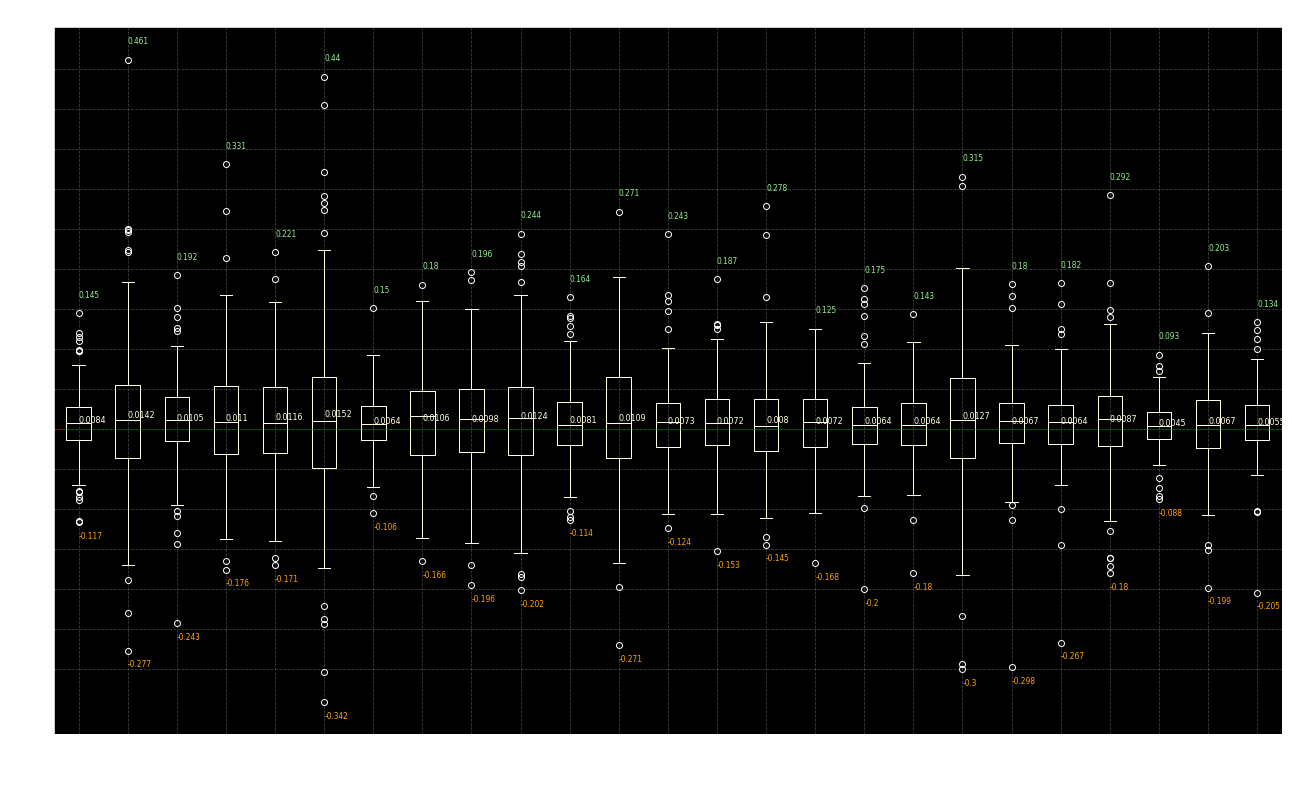

,count,mean,std,min,2.5%,25%,50%,75%,95%,max,mode,skewness,kurtosis
LLY,39.0,0.035824,0.086717,-0.120714,-0.116254,-0.016603,0.038223,0.099590,0.149452,0.218815,-0.120714,-0.186039,-0.814274
EQT,39.0,0.060256,0.190651,-0.303702,-0.219701,-0.027932,0.040628,0.125942,0.288209,0.785913,-0.303702,1.296629,3.858506
PWR,39.0,0.044758,0.086778,-0.147139,-0.120606,0.007632,0.052844,0.096693,0.179521,0.253868,-0.147139,-0.042665,0.088955
FSLR,39.0,0.046798,0.154780,-0.194779,-0.186334,-0.072388,0.041993,0.179933,0.270241,0.404251,-0.194779,0.248729,-0.811802
NVDA,39.0,0.049227,0.150344,-0.368077,-0.213133,-0.022407,0.064015,0.164835,0.248705,0.303955,-0.368077,-0.573224,0.016013
MRNA,39.0,0.064727,0.252222,-0.377496,-0.347122,-0.095784,0.052633,0.157402,0.478104,0.871581,-0.377496,0.824606,1.286624
MCK,39.0,0.027223,0.064121,-0.076684,-0.074690,-0.016917,0.013953,0.058464,0.139089,0.209131,-0.076684,0.801247,0.374337
STLD,39.0,0.045134,0.118828,-0.240008,-0.138137,-0.054193,0.048125,0.117075,0.222968,0.293126,-0.240008,-0.047771,-0.426445
NUE,39.0,0.041602,0.137570,-0.224513,-0.201299,-0.047855,0.027728,0.133603,0.270440,0.309861,-0.224513,0.113514,-0.736012
ON,39.0,0.052902,0.132410,-0.264716,-0.184352,0.011152,0.053626,0.139175,0.264338,0.298621,-0.264716,-0.341829,-0.156725


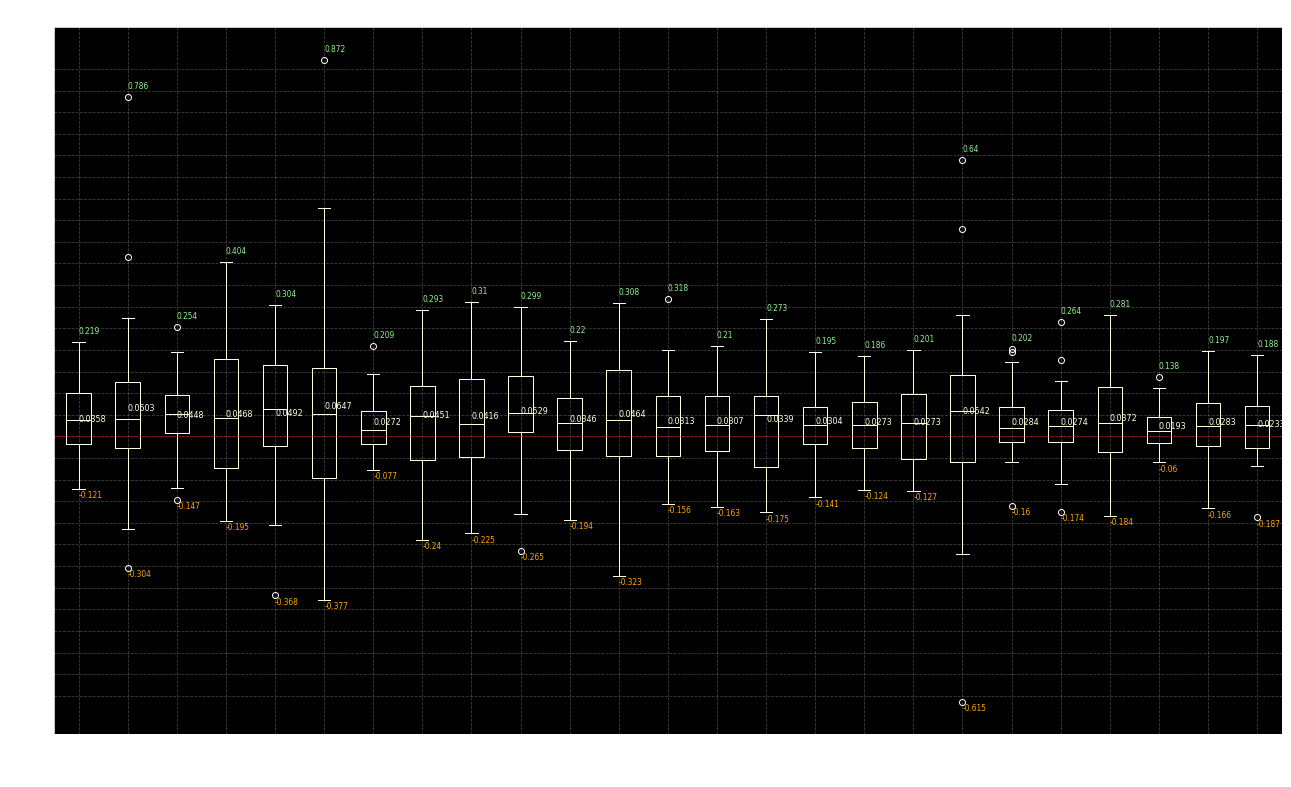

,count,mean,std,min,2.5%,25%,50%,75%,95%,max,mode,skewness,kurtosis
LLY,14.0,0.099795,0.101480,-0.093015,-0.080354,0.024486,0.128494,0.184271,0.223397,0.224663,-0.093015,-0.492581,-0.888542
EQT,14.0,0.167857,0.220751,-0.144545,-0.111848,0.022286,0.110250,0.259772,0.538473,0.619836,-0.144545,0.667261,-0.504785
PWR,14.0,0.124684,0.138050,-0.147139,-0.107089,0.029535,0.144288,0.236734,0.316429,0.323224,-0.147139,-0.241660,-0.812972
FSLR,14.0,0.130365,0.278333,-0.185890,-0.185765,-0.080125,0.065215,0.352624,0.535367,0.703811,-0.185890,0.549166,-0.771473
NVDA,14.0,0.137132,0.305133,-0.526957,-0.415047,-0.007298,0.050473,0.388629,0.512975,0.680798,-0.526957,-0.289932,-0.007561
MRNA,14.0,0.180311,0.384479,-0.298813,-0.298552,-0.134548,0.127955,0.488762,0.721416,0.895174,-0.298813,0.336396,-1.157256
MCK,14.0,0.075836,0.093569,-0.061134,-0.056429,-0.000452,0.061772,0.143454,0.219828,0.228284,-0.061134,0.161926,-1.112913
STLD,14.0,0.125730,0.176597,-0.201306,-0.178503,0.025543,0.148657,0.259651,0.347655,0.349931,-0.201306,-0.393424,-0.883680
NUE,14.0,0.115891,0.186968,-0.318235,-0.247524,0.054692,0.177537,0.201086,0.345083,0.436284,-0.318235,-0.694839,0.456883
ON,14.0,0.147371,0.241911,-0.264716,-0.235315,-0.022043,0.155318,0.297463,0.471730,0.551668,-0.264716,-0.032399,-0.985170


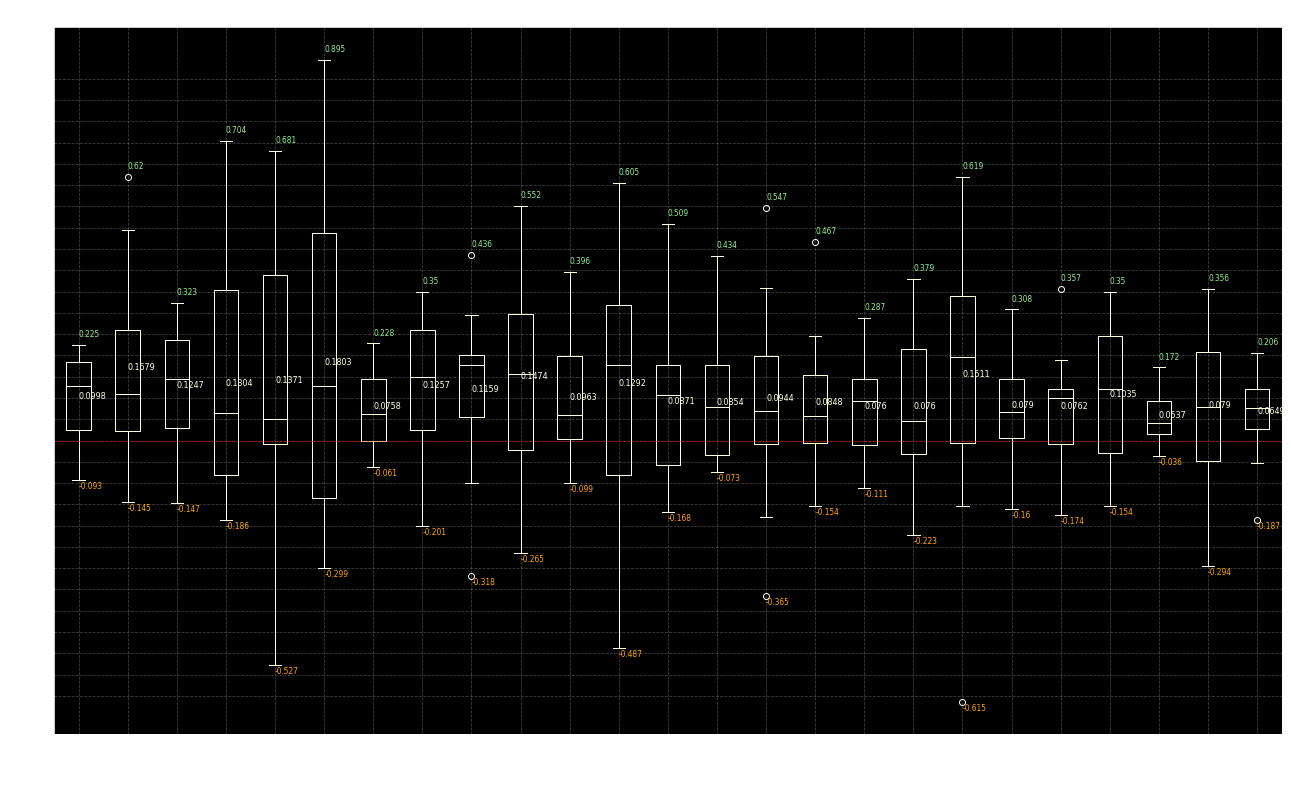

In [97]:
P = [["W", "Weekly"], ["M", "Monthly"], ["Q", "Qtrly."]]
describe = [Stats(SP_Assets_r.loc["2020-03-02":today], Sortino25[2], P[i][0], "S&P 500 Resampling Stats for Sortino Selection on a " + str(P[i][1]) + " basis from ",
                    "2020-03-02", today, [.025, .25, .5, .75, .95], color="lightyellow") for i in range(0, len(P))]

### <font color= 'lightblue'> 3. Prescriptive Analytics <font> </span>

##### <font color= 'lightblue'> 3.1 <u>$X_P$<u> Optimizations Prescriptive Models <font>

<span style='color:lightgray'> *Equal weighted datasets are omitted from the analysis for simplicity purposes.* <font>

If we have $n$ unequally weighted datasets $X_i=1,2,.., n$, their weighted average can be concluded:<br>

$$\mu_{P} = \sum_{i=1}^{n} w_{i} \mu_{{X_{i}}}$$ 

For $X_P$ variance $\sigma^2_P$ we need the correlation coefficients for $X_{i,j}$ expressed as $\rho_{i j}$ = $\frac{Cov(X_i, X_{j})}{\sigma_{i} \sigma_{j}}$ and thus, their fluctuations directional relationship.<br>
So it can be expressed as:

$$\sigma^2_P=\sum_{i=1}^{n}\sum_{j=1}^{n}w_{i}w_{j}\sigma_{i}\sigma_{j}\rho_{ij}$$ 


By substitution we are left with: 

$$\sigma^2_P = \sum_{i=1}^{n}\sum_{j=1}^{n}w_{i}w_{j}Cov(X_i, X_j)$$

Which needs to be expressed as a product of matrices $\times$ vectors:<br>

$\sigma^2_{P} = \vec{w}^T \times Cov_{i,j} \times \vec{w}$<br>

Expressed as the following in its expanded form:<br> 

$$\sigma^2_{P} = {\left[\begin{array}{cccc}w_{1} & w_{2} & \cdots & w_{n}\end{array}\right] \cdot \left[\begin{array}{cccc}1 & \rho_{1,2} & \cdots & \rho_{1,n} \\ \rho_{2,1} & 1 & \cdots & \rho_{2,n} \\ \vdots & \vdots & \ddots & \vdots \\ p_{n,1} & \cdots & \cdots & 1\end{array}\right] \cdot \left[\begin{array}{cccc}w_{1} \\ w_{2} \\ \vdots \\ w_{n}\end{array}\right]}$$

Having obtained its variance, the Ratios include sensitivities $\beta$ for $X_P:$ 

$\beta({r_P, r_{t_{S\&P500}}})$ = $\frac{Cov(r_P,r_{t_{S\&P500}})}{Var(r_{t_{S\&P500}})}$ 

To compute the metrics we substitute $\beta^{-1}$ $\times$ their excess returns.
+ $R_{Treynor}({r_P, r_{t_{S\&P500}}}) = \frac{Var(R_{mkt})[\mu_P - {rf}]}{Cov(r_P,r_{t_{S\&P500}})}$ or units of slope sensitivities per unit of $P$ excess returns.

+ $R_{Jensen}({r_P, r_{t_{S\&P500}}}) = {rf} + \frac{Var(r_{t_{S\&P500}})[r_{t_{S\&P500}} - {rf}]}{Cov(r_P,r_{t_{S\&P500}})}$ or units of slope sensitivities per unit of $S\&P500$ excess returns, + $r_f$.

Optimizations can now made and validated for given metrics as it is required: <br><br>
+ $R_{Treynor_{Arg_{max}}}$
+ $R_{Sharpe_{Arg_{max}}}$
+ $R_{Sortino_{Arg_{max}}}$
+ $\sigma^2_{P_{Arg_{min}}}$

In [31]:
def Optimizer(Assets, index, rf, title):
    Asset_ret = (Assets.pct_change()).iloc[1:, :].dropna(axis = 1)
    index_ret = index.pct_change().iloc[1:, :].dropna(axis = 1)
    index_ret = index_ret[index_ret.index.isin(Asset_ret.index)]

    mean_ret = Asset_ret.mean() * 252
    cov = Asset_ret.cov() * 252

    N = len(mean_ret)
    w0 = np.ones(N) / N
    bnds = ((0, None), ) * N
    cons = {"type" : "eq", "fun" : lambda weights : weights.sum() - 1}

    def Max_Sharpe(weights, Asset_ret, rf, cov):
        rp = np.dot(weights.T, Asset_ret)
        sp = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        RS = (rp - rf) / sp
        return -(np.divide(np.subtract(rp, rf), sp))
    
    def Min_Var(weights, cov):
        return np.dot(weights.T, np.dot(cov, weights)) 
    
    # def Min_Traynor(weights, Asset_ret, rf, cov):
    #     rp = np.dot(weights.T, Asset_ret)
    #     varp = np.dot(weights.T, np.dot(cov, weights))
    #     RT = (rp - rf) / sp
    #     return -(np.divide(np.subtract(rp, rf), sp))
    
    #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    opt_EMV = optimize.minimize(Max_Sharpe, w0, (mean_ret, rf, cov), 'SLSQP', bounds = bnds,
                                constraints = cons, options={"tol": 1e-10})
    
    W_EMV = pd.DataFrame(np.round(opt_EMV.x.reshape(1, N), 4), columns = Asset_ret.columns, index = ["Weights"])
    W_EMV[W_EMV <= 0.0] = np.nan
    W_EMV.dropna(axis = 1, inplace = True)

    RAssets = Asset_ret[Asset_ret.columns[Asset_ret.columns.isin(W_EMV.columns)]]
    # MuAssets = mean_ret[mean_ret.index.isin(W_EMV.columns)]
    R_EMV = pd.DataFrame((RAssets*W_EMV.values).sum(axis = 1), columns = ["$r_{Sharpe_{Arg_{max}}}$"])
    index_ret.rename(columns={index_ret.columns[0]: "$r_{mkt}$" }, inplace=True)
    R_EMV.insert(1, index_ret.columns[0], index_ret.values)

    Muopt_EMV = np.dot(opt_EMV.x.T, mean_ret) 
    Sopt_EMV = np.sqrt(np.dot(opt_EMV.x.T, np.dot(cov, opt_EMV.x)))
    Beta_EMV = np.divide((np.cov(R_EMV.iloc[0], R_EMV.iloc[1])[0][1]), R_EMV.iloc[1].var())
    SR_EMV = (Muopt_EMV - rf) / Sopt_EMV

    #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------

    opt_MinVar = optimize.minimize(Min_Var, np.ones(N) / N, (cov,), 'SLSQP', bounds = bnds,
                                   constraints = cons, options={"tol": 1e-10})

    W_MinVar = pd.DataFrame(np.round(opt_MinVar.x.reshape(1, N), 4), columns = Asset_ret.columns, index = ["Weights"])
    W_MinVar[W_MinVar <= 0.0] = np.nan
    W_MinVar.dropna(axis = 1, inplace = True)

    RAssets_MinVar = Asset_ret[Asset_ret.columns[Asset_ret.columns.isin(W_MinVar.columns)]]
    R_MinVar = pd.DataFrame((RAssets_MinVar*W_MinVar.values).sum(axis = 1), columns = ["$r_{Var_{Arg_{min}}}$"])
    R_EMV.insert(2, R_MinVar.columns[0], R_MinVar.values)

    Muopt_MinVar = np.dot(opt_MinVar.x.T, mean_ret) 
    Sopt_MinVar = np.sqrt(np.dot(opt_MinVar.x.T, np.dot(cov, opt_MinVar.x)))
    Beta_MinVar = np.divide((np.cov(R_EMV.iloc[2], R_EMV.iloc[1])[0][1]), R_EMV.iloc[1].var())
    SR_MinVar = (Muopt_MinVar - rf) / Sopt_MinVar

    #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------
    #opt_Traynor = 













    #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------

    Mu, Sigma, Beta, SR = [Muopt_EMV, Muopt_MinVar], [Sopt_EMV, Sopt_MinVar], [Beta_EMV, Beta_MinVar], [SR_EMV, SR_MinVar]
    index = ["$r_{P{Sharpe_{Arg_{max}}}}$", "$r_{Var_{Arg_{min}}}$"]
    Popt = [pd.DataFrame({"$\mu_P$" : Mu[i], "$\sigma_P$" : Sigma[i], "$\Beta_{P}$": Beta[i], "$r_{Sharpe_{Arg_{max}}}$" : SR[i]},
                          index = [index[i]]) for i in range(0, len(Mu))]
    
    Popt[0].index.name = title
    Popt[1].index.name = title
    R_EMV = R_EMV[[R_EMV.columns[1], R_EMV.columns[2], R_EMV.columns[0]]]
    #Get the cumulative returns with cumsum for rmkt, rEMV and rMinVar
    accum = R_EMV.cumsum()

    Argmax = [d.Markdown(tabulate(Popt[i], headers = "keys", tablefmt = "pipe")) for i in range(0, len(Popt))]
    R_EMV = d.Markdown(tabulate(R_EMV, headers = "keys", tablefmt = "pipe"))
    
    return Argmax, R_EMV, accum

In [32]:
bench_md = "$S\&P500_{{20_{03}-23_{05}}}$"
Argmax, R_EMV, accum = Optimizer(SP_Assets_r.loc["2018-01-02":"2020-01-02"], dt.get_historical_price_data('^GSPC', 6).loc["2018-01-02":"2020-01-02"],
                                  0.0169, bench_md)
d.display(Argmax[0], Argmax[1], R_EMV)

| $S\&P500_{{20_{03}-23_{05}}}$   |   $\mu_P$ |   $\sigma_P$ |   $\Beta_{P}$ |   $r_{Sharpe_{Arg_{max}}}$ |
|:--------------------------------|----------:|-------------:|--------------:|---------------------------:|
| $r_{P{Sharpe_{Arg_{max}}}}$     |  0.479138 |      0.13457 |      0.270972 |                    3.43492 |

| $S\&P500_{{20_{03}-23_{05}}}$   |   $\mu_P$ |   $\sigma_P$ |   $\Beta_{P}$ |   $r_{Sharpe_{Arg_{max}}}$ |
|:--------------------------------|----------:|-------------:|--------------:|---------------------------:|
| $r_{Var_{Arg_{min}}}$           |  0.119933 |    0.0829575 |      0.274338 |                      1.242 |

| formatted_date   |    $r_{mkt}$ |   $r_{Var_{Arg_{min}}} |   $r_{Sharpe_{Arg_{max}}}$ |
|:-----------------|-------------:|-----------------------:|---------------------------:|
| 2018-01-03       |  0.00639882  |           -0.00143561  |                0.00411452  |
| 2018-01-04       |  0.00402864  |            0.00156839  |               -0.00440139  |
| 2018-01-05       |  0.00703377  |            0.00156177  |                0.00355195  |
| 2018-01-08       |  0.00166234  |            0.00154358  |                0.00491802  |
| 2018-01-09       |  0.00130293  |           -0.000709255 |               -0.00552457  |
| 2018-01-10       | -0.00111223  |           -0.00353402  |               -0.0018214   |
| 2018-01-11       |  0.00703365  |            0.00340936  |                0.0110895   |
| 2018-01-12       |  0.0067496   |            0.00227316  |               -0.00248432  |
| 2018-01-16       | -0.00352449  |            0.00274127  |               -0.00890288  |
| 2018-01-17       |  0.00941505  |            0.00199562  |                0.00964043  |
| 2018-01-18       | -0.00161639  |           -0.00330674  |               -0.00378034  |
| 2018-01-19       |  0.00438524  |            0.00504237  |                0.00597891  |
| 2018-01-22       |  0.00806673  |            0.00807313  |                0.00268155  |
| 2018-01-23       |  0.00217437  |            0.00104826  |                0.00539896  |
| 2018-01-24       | -0.000559976 |            0.00202362  |               -0.0068806   |
| 2018-01-25       |  0.000602621 |           -0.000599766 |                0.00980422  |
| 2018-01-26       |  0.0118412   |            0.00399767  |                0.00931285  |
| 2018-01-29       | -0.00673197  |            0.00185039  |                0.0178032   |
| 2018-01-30       | -0.0108988   |           -0.000362701 |               -0.00370821  |
| 2018-01-31       |  0.000488985 |            0.00601333  |                0.0129275   |
| 2018-02-01       | -0.000648088 |           -0.00668986  |               -0.0097643   |
| 2018-02-02       | -0.0212085   |           -0.0117081   |               -0.0160634   |
| 2018-02-05       | -0.0409792   |           -0.0215414   |               -0.0112204   |
| 2018-02-06       |  0.0174409   |           -0.00118341  |               -0.00234444  |
| 2018-02-07       | -0.00500159  |           -0.002562    |               -0.0051373   |
| 2018-02-08       | -0.0375364   |           -0.0178094   |               -0.0264173   |
| 2018-02-09       |  0.0149361   |            0.00763082  |                0.00482165  |
| 2018-02-12       |  0.0139146   |            0.00592354  |                0.0200113   |
| 2018-02-13       |  0.00261293  |           -0.00196131  |                0.00734428  |
| 2018-02-14       |  0.0134025   |            0.00503205  |                0.0159169   |
| 2018-02-15       |  0.0120691   |            0.00681574  |                0.0143038   |
| 2018-02-16       |  0.000373469 |           -0.00412406  |                0.0104199   |
| 2018-02-20       | -0.00584139  |           -0.00831018  |               -0.00937261  |
| 2018-02-21       | -0.0054965   |           -0.00248099  |               -0.0027928   |
| 2018-02-22       |  0.000973551 |            0.000757489 |               -0.0059095   |
| 2018-02-23       |  0.0160284   |            0.0145628   |                0.0141536   |
| 2018-02-26       |  0.011757    |            0.00507123  |                0.00891315  |
| 2018-02-27       | -0.0127069   |           -0.0126461   |               -0.00394694  |
| 2018-02-28       | -0.0110958   |           -0.00299532  |                0.0174962   |
| 2018-03-01       | -0.0133244   |           -0.000392128 |               -0.00212766  |
| 2018-03-02       |  0.0050716   |           -0.00234175  |                0.0064528   |
| 2018-03-05       |  0.011032    |            0.011632    |                0.0147289   |
| 2018-03-06       |  0.00263886  |            0.00312581  |                0.00413454  |
| 2018-03-07       | -0.000483875 |           -0.00404387  |                0.00178134  |
| 2018-03-08       |  0.00446308  |            0.00263669  |                0.000987698 |
| 2018-03-09       |  0.0173788   |            0.0076743   |                0.0075299   |
| 2018-03-12       | -0.00127399  |           -0.000108673 |                0.00651493  |
| 2018-03-13       | -0.00636358  |           -0.00170891  |                0.000953107 |
| 2018-03-14       | -0.00572452  |           -0.00148892  |                0.00637553  |
| 2018-03-15       | -0.000781931 |           -0.00408885  |                0.00131268  |
| 2018-03-16       |  0.00170345  |            0.00822068  |                0.0114356   |
| 2018-03-19       | -0.0142042   |           -0.00536948  |               -0.00428032  |
| 2018-03-20       |  0.00148181  |           -0.000730694 |                0.00356095  |
| 2018-03-21       | -0.00184399  |            0.000773315 |                0.00460311  |
| 2018-03-22       | -0.0251629   |           -0.0117153   |               -0.00232413  |
| 2018-03-23       | -0.0209669   |           -0.0068666   |               -0.00928133  |
| 2018-03-26       |  0.0271573   |            0.0152772   |                0.0141787   |
| 2018-03-27       | -0.0172763   |           -0.00283786  |               -0.00121556  |
| 2018-03-28       | -0.00291666  |           -0.00134051  |               -0.00715292  |
| 2018-03-29       |  0.0137697   |            0.00618577  |                0.00815992  |
| 2018-04-02       | -0.0223374   |           -0.00925269  |               -0.0138632   |
| 2018-04-03       |  0.0126149   |            0.00464923  |                0.00198726  |
| 2018-04-04       |  0.0115665   |            0.00638297  |                0.00857679  |
| 2018-04-05       |  0.00686286  |            0.00283578  |                0.00568541  |
| 2018-04-06       | -0.0219202   |           -0.0117669   |               -0.0158085   |
| 2018-04-09       |  0.00333655  |           -0.000165822 |               -0.000341537 |
| 2018-04-10       |  0.016727    |            0.00651302  |                0.00472677  |
| 2018-04-11       | -0.00552536  |           -0.000156773 |               -0.000427377 |
| 2018-04-12       |  0.00825075  |           -0.00300487  |                0.000873822 |
| 2018-04-13       | -0.00288663  |            0.00242321  |               -0.00349785  |
| 2018-04-16       |  0.00810904  |            0.00554836  |                0.00944901  |
| 2018-04-17       |  0.0106615   |            0.00577002  |                0.0153492   |
| 2018-04-18       |  0.000831366 |           -0.00213544  |               -0.000912258 |
| 2018-04-19       | -0.00572612  |           -0.000413625 |                0.00202639  |
| 2018-04-20       | -0.00853653  |           -0.00503375  |               -0.00350624  |
| 2018-04-23       |  5.62317e-05 |           -0.00056604  |                0.00338532  |
| 2018-04-24       | -0.0133806   |           -0.00028344  |               -0.0076819   |
| 2018-04-25       |  0.00183706  |            0.00102939  |               -0.000984389 |
| 2018-04-26       |  0.0104342   |            0.00530841  |                0.0338841   |
| 2018-04-27       |  0.00111362  |            0.00506466  |                0.000803134 |
| 2018-04-30       | -0.00818749  |           -0.00401143  |               -0.0058872   |
| 2018-05-01       |  0.00254905  |           -0.00636524  |               -0.00329453  |
| 2018-05-02       | -0.00720586  |           -0.00414531  |                0.0102302   |
| 2018-05-03       | -0.00225367  |            0.000111324 |                0.00209522  |
| 2018-05-04       |  0.0128112   |            0.00422524  |                0.00511937  |
| 2018-05-07       |  0.00345795  |            9.34554e-05 |                0.007214    |
| 2018-05-08       | -0.000265641 |           -0.00445674  |               -0.00744897  |
| 2018-05-09       |  0.00968222  |            0.00632625  |                0.0135793   |
| 2018-05-10       |  0.00937064  |            0.00630762  |                0.0145236   |
| 2018-05-11       |  0.0017076   |            0.00220905  |                0.00232293  |
| 2018-05-14       |  0.00088349  |            0.000315429 |                0.00140838  |
| 2018-05-15       | -0.00684214  |           -0.00606873  |               -0.00262653  |
| 2018-05-16       |  0.00406056  |            0.000586187 |                0.00826327  |
| 2018-05-17       | -0.000855872 |           -0.0040796   |               -0.00338034  |
| 2018-05-18       | -0.00263219  |           -0.0041574   |               -0.00451106  |
| 2018-05-21       |  0.00738675  |            0.00434978  |                0.0117301   |
| 2018-05-22       | -0.00313576  |           -0.00514076  |               -0.00556804  |
| 2018-05-23       |  0.00324841  |            0.00491528  |                0.00477344  |
| 2018-05-24       | -0.00202321  |            0.00350436  |                0.00680697  |
| 2018-05-25       | -0.00235722  |            0.0019108   |               -0.000772513 |
| 2018-05-29       | -0.0115642   |           -0.00430382  |                0.00402398  |
| 2018-05-30       |  0.0126958   |            0.00798692  |                0.0165472   |
| 2018-05-31       | -0.00687956  |           -0.00607438  |               -0.0101772   |
| 2018-06-01       |  0.0108492   |           -0.000920186 |                0.00610548  |
| 2018-06-04       |  0.0044796   |            0.000447336 |                0.00508064  |
| 2018-06-05       |  0.000702593 |           -0.000395102 |               -0.00123303  |
| 2018-06-06       |  0.00856739  |           -0.000602053 |               -0.00875818  |
| 2018-06-07       | -0.000714188 |            0.00390251  |               -0.00420688  |
| 2018-06-08       |  0.0031259   |            0.00178476  |                0.00348215  |
| 2018-06-11       |  0.00106871  |            0.00255454  |                0.00198821  |
| 2018-06-12       |  0.00174339  |            0.00465165  |                0.00388634  |
| 2018-06-13       | -0.00402613  |           -0.00284811  |                0.0225496   |
| 2018-06-14       |  0.00247155  |            0.00390133  |                0.0103717   |
| 2018-06-15       | -0.0010171   |           -0.00292032  |               -0.00562132  |
| 2018-06-18       | -0.00212613  |            0.000338015 |                0.0102858   |
| 2018-06-19       | -0.0040234   |            0.00324955  |                0.00396137  |
| 2018-06-20       |  0.00171215  |            0.000452336 |               -0.00109036  |
| 2018-06-21       | -0.00634551  |           -0.000689053 |               -0.00291684  |
| 2018-06-22       |  0.00186193  |            0.00591547  |                0.00850271  |
| 2018-06-25       | -0.0137247   |           -0.00342312  |               -0.00295835  |
| 2018-06-26       |  0.00220458  |            0.00122179  |                0.00508913  |
| 2018-06-27       | -0.00860436  |            0.00298462  |               -0.0093067   |
| 2018-06-28       |  0.00617869  |           -0.000453352 |                0.00129113  |
| 2018-06-29       |  0.000758403 |            0.00137016  |               -0.0015889   |
| 2018-07-02       |  0.00306796  |            0.00190189  |                0.0128773   |
| 2018-07-03       | -0.00494735  |           -0.00275978  |               -0.000577213 |
| 2018-07-05       |  0.0086208   |            0.00981869  |                0.00461362  |
| 2018-07-06       |  0.00848128  |            0.00364741  |                0.0067445   |
| 2018-07-09       |  0.00882299  |           -0.00309116  |                0.000820974 |
| 2018-07-10       |  0.00347327  |            0.00845508  |                0.0149387   |
| 2018-07-11       | -0.0070942   |            0.000585854 |                0.00642353  |
| 2018-07-12       |  0.00874904  |            0.00487836  |                0.00811133  |
| 2018-07-13       |  0.00107924  |           -0.00323409  |               -0.00384478  |
| 2018-07-16       | -0.00102814  |            0.000156107 |               -0.00222414  |
| 2018-07-17       |  0.0039737   |            0.000390735 |                0.00284216  |
| 2018-07-18       |  0.00216051  |           -0.000229899 |               -0.00192629  |
| 2018-07-19       | -0.00395299  |            0.000988988 |                0.00706305  |
| 2018-07-20       | -0.000948448 |           -0.00252775  |               -0.00558669  |
| 2018-07-23       |  0.00183805  |           -0.00310309  |               -0.00199514  |
| 2018-07-24       |  0.00478091  |           -0.00123002  |               -0.00569583  |
| 2018-07-25       |  0.00910161  |            0.00401153  |                0.000862371 |
| 2018-07-26       | -0.0030323   |            0.0033678   |                0.0019534   |
| 2018-07-27       | -0.00656221  |           -0.00521597  |               -0.0118239   |
| 2018-07-30       | -0.00575417  |           -0.00608888  |               -0.00578407  |
| 2018-07-31       |  0.00488473  |            0.00857731  |                0.00307252  |
| 2018-08-01       | -0.00104035  |           -0.00486747  |                0.00202     |
| 2018-08-02       |  0.00492644  |           -0.00167219  |                0.0233851   |
| 2018-08-03       |  0.00464418  |            0.00525053  |               -0.000112655 |
| 2018-08-06       |  0.00353823  |           -0.000209165 |                0.00858669  |
| 2018-08-07       |  0.00282418  |            0.00121805  |                0.00373052  |
| 2018-08-08       | -0.00026238  |           -0.00594976  |               -0.00369472  |
| 2018-08-09       | -0.00144167  |           -0.00118886  |                0.000310174 |
| 2018-08-10       | -0.00711389  |           -0.00485685  |               -0.00106571  |
| 2018-08-13       | -0.00400599  |           -0.003681    |               -0.00608702  |
| 2018-08-14       |  0.00638925  |            0.0030398   |                0.00281812  |
| 2018-08-15       | -0.00760216  |           -0.00518477  |               -0.00151005  |
| 2018-08-16       |  0.00791941  |            0.00479466  |                0.00603501  |
| 2018-08-17       |  0.00332312  |            0.00505657  |                0.003523    |
| 2018-08-20       |  0.00242802  |            0.000585472 |                0.00308614  |
| 2018-08-21       |  0.00206854  |           -0.00114121  |               -0.0021738   |
| 2018-08-22       | -0.000398152 |           -0.00414513  |                0.00373326  |
| 2018-08-23       | -0.00169126  |           -0.00119122  |                0.0023176   |
| 2018-08-24       |  0.00619884  |            0.00591234  |                0.00425425  |
| 2018-08-27       |  0.00767041  |           -0.000509774 |               -0.00552238  |
| 2018-08-28       |  0.000269278 |           -0.00167662  |                0.00299997  |
| 2018-08-29       |  0.00570143  |            0.0014223   |                0.00515389  |
| 2018-08-30       | -0.00443033  |           -0.0031892   |               -0.00939723  |
| 2018-08-31       |  0.000134478 |            0.00112413  |                0.000106307 |
| 2018-09-04       | -0.00165432  |           -0.000768514 |                0.00547838  |
| 2018-09-05       | -0.00280313  |            0.00368517  |               -0.0023124   |
| 2018-09-06       | -0.00365231  |            0.000547939 |               -0.000741114 |
| 2018-09-07       | -0.00221334  |           -0.000805124 |               -0.00318082  |
| 2018-09-10       |  0.00189783  |           -0.000386786 |                0.00808655  |
| 2018-09-11       |  0.00373984  |           -0.00660136  |                0.00168923  |
| 2018-09-12       |  0.000356672 |            0.00533339  |                0.00553556  |
| 2018-09-13       |  0.00528225  |            0.00183065  |               -0.0028612   |
| 2018-09-14       |  0.000275482 |           -0.00197523  |               -0.000102281 |
| 2018-09-17       | -0.00556972  |           -0.000687177 |               -0.0121764   |
| 2018-09-18       |  0.00536901  |            0.0010668   |                0.0100781   |
| 2018-09-19       |  0.00125327  |           -0.00412824  |               -0.0135742   |
| 2018-09-20       |  0.00784059  |            0.00330099  |                0.00425442  |
| 2018-09-21       | -0.000368533 |            0.00283157  |               -0.0015983   |
| 2018-09-24       | -0.00351569  |           -0.00752065  |               -0.00737071  |
| 2018-09-25       | -0.0013051   |           -0.00310661  |                0.00667748  |
| 2018-09-26       | -0.00328928  |           -0.00786807  |               -0.00797683  |
| 2018-09-27       |  0.00276329  |            0.000208863 |                0.00797956  |
| 2018-09-28       | -6.87012e-06 |            0.00483867  |                0.00186009  |
| 2018-10-01       |  0.00364111  |           -0.00383018  |               -0.00525923  |
| 2018-10-02       | -0.00039669  |            0.00482485  |               -0.000987213 |
| 2018-10-03       |  0.00071152  |           -0.00958458  |               -0.00387399  |
| 2018-10-04       | -0.00816948  |            0.00129748  |               -0.00171839  |
| 2018-10-05       | -0.00552798  |            0.00249536  |                0.00354759  |
| 2018-10-08       | -0.000395117 |            0.00798613  |                0.0035853   |
| 2018-10-09       | -0.0014179   |            0.000292886 |                0.00193488  |
| 2018-10-10       | -0.0328642   |           -0.00917079  |               -0.0158062   |
| 2018-10-11       | -0.020573    |           -0.00862997  |               -0.00968249  |
| 2018-10-12       |  0.0142062   |            0.00146831  |                0.0118887   |
| 2018-10-15       | -0.00590498  |            0.00565668  |                0.00827879  |
| 2018-10-16       |  0.0214956   |            0.00890221  |                0.0176956   |
| 2018-10-17       | -0.000252662 |           -1.97418e-05 |               -0.00612902  |
| 2018-10-18       | -0.0143919   |           -1.59867e-05 |               -0.00369671  |
| 2018-10-19       | -0.00036117  |            0.00251356  |               -0.00144211  |
| 2018-10-22       | -0.00429953  |           -0.00548121  |                0.00181123  |
| 2018-10-23       | -0.00551183  |            0.0030924   |               -0.0084035   |
| 2018-10-24       | -0.0308644   |           -0.00283886  |               -0.00854223  |
| 2018-10-25       |  0.018625    |           -0.00527093  |                4.25068e-05 |
| 2018-10-26       | -0.0173273   |           -0.00549811  |               -0.0133023   |
| 2018-10-29       | -0.0065596   |            0.0103087   |                0.00452864  |
| 2018-10-30       |  0.0156668   |            0.0108226   |                0.017224    |
| 2018-10-31       |  0.0108513   |           -0.0017595   |                0.0144586   |
| 2018-11-01       |  0.0105578   |            0.00492062  |                0.0173306   |
| 2018-11-02       | -0.00631669  |           -0.000447792 |                0.00220196  |
| 2018-11-05       |  0.00560032  |            0.00388486  |                0.00718266  |
| 2018-11-06       |  0.0062593   |            0.014813    |                0.00925076  |
| 2018-11-07       |  0.0212089   |            0.00809471  |                0.0156246   |
| 2018-11-08       | -0.00250892  |            0.0021808   |                0.00765541  |
| 2018-11-09       | -0.00919901  |            0.00154592  |                0.00148028  |
| 2018-11-12       | -0.0197015   |           -0.00465408  |               -0.00760249  |
| 2018-11-13       | -0.00148192  |            0.0030887   |               -0.000811941 |
| 2018-11-14       | -0.00756741  |            0.000804821 |               -0.00404489  |
| 2018-11-15       |  0.0105938   |            0.00299166  |                0.00268271  |
| 2018-11-16       |  0.00222331  |            0.00817849  |                0.00383538  |
| 2018-11-19       | -0.0166431   |           -0.00356641  |               -0.0172519   |
| 2018-11-20       | -0.0181512   |           -0.0100362   |               -0.0258691   |
| 2018-11-21       |  0.00304329  |           -0.00196742  |                0.00601148  |
| 2018-11-23       | -0.00655484  |           -0.00288021  |                0.00360526  |
| 2018-11-26       |  0.0155324   |            0.00461789  |                0.00663049  |
| 2018-11-27       |  0.00326169  |            0.00137477  |                0.00235275  |
| 2018-11-28       |  0.022974    |            0.00410527  |                0.0124736   |
| 2018-11-29       | -0.00218311  |            0.00447558  |               -0.00362044  |
| 2018-11-30       |  0.00817075  |            0.00291369  |                0.00291544  |
| 2018-12-03       |  0.0109414   |            0.00233559  |                0.0152147   |
| 2018-12-04       | -0.0323649   |           -0.00436652  |               -0.0102761   |
| 2018-12-06       | -0.00152223  |           -0.000897046 |                0.00252738  |
| 2018-12-07       | -0.0233201   |           -0.00296059  |               -0.00857536  |
| 2018-12-10       |  0.00176215  |            8.14114e-05 |                0.00618313  |
| 2018-12-11       | -0.000356346 |           -0.00487754  |                0.00135629  |
| 2018-12-12       |  0.0054195   |            0.000175509 |                0.0046578   |
| 2018-12-13       | -0.00019993  |           -0.00163736  |               -4.58692e-05 |
| 2018-12-14       | -0.0190867   |           -0.00784509  |               -0.011158    |
| 2018-12-17       | -0.0207735   |           -0.0175385   |               -0.0317994   |
| 2018-12-18       |  8.64006e-05 |           -0.00144903  |               -0.00402156  |
| 2018-12-19       | -0.0153957   |           -0.0110998   |               -0.0131019   |
| 2018-12-20       | -0.0157721   |           -0.00439278  |               -0.0142635   |
| 2018-12-21       | -0.0205882   |           -0.011474    |               -0.0148707   |
| 2018-12-24       | -0.0271123   |           -0.0203493   |               -0.0236378   |
| 2018-12-26       |  0.0495937   |            0.0187846   |                0.0383662   |
| 2018-12-27       |  0.00856268  |            0.00515007  |                0.00575063  |
| 2018-12-28       | -0.00124158  |            0.00611422  |                0.00218894  |
| 2018-12-31       |  0.00849248  |            0.0047512   |                0.00799109  |
| 2019-01-02       |  0.0012685   |           -0.00875984  |               -0.00377539  |
| 2019-01-03       | -0.0247567   |           -0.00255908  |               -0.0116718   |
| 2019-01-04       |  0.0343357   |            0.0126188   |                0.0290537   |
| 2019-01-07       |  0.00701043  |            0.00221906  |                0.0203565   |
| 2019-01-08       |  0.00969529  |            0.00658727  |                0.0109883   |
| 2019-01-09       |  0.00409805  |           -0.000661678 |                0.00840525  |
| 2019-01-10       |  0.00451842  |            0.00672239  |                0.0071439   |
| 2019-01-11       | -0.000146298 |            0.000251263 |                0.0037605   |
| 2019-01-14       | -0.00525753  |           -0.0129243   |               -0.0119622   |
| 2019-01-15       |  0.0107217   |            0.00275186  |                0.0155162   |
| 2019-01-16       |  0.00222199  |            0.00317729  |                0.00792205  |
| 2019-01-17       |  0.0075914   |            0.00849609  |                0.00767851  |
| 2019-01-18       |  0.0131831   |            0.00564827  |                0.00161727  |
| 2019-01-22       | -0.0141573   |           -0.000784506 |               -0.00145191  |
| 2019-01-23       |  0.00220291  |            0.00559043  |                0.00283279  |
| 2019-01-24       |  0.00137573  |           -0.000314725 |                0.00215659  |
| 2019-01-25       |  0.00848869  |            0.00335776  |                0.000370083 |
| 2019-01-28       | -0.00784683  |           -0.000484094 |               -0.00575031  |
| 2019-01-29       | -0.00145625  |            0.00270657  |                0.0023198   |
| 2019-01-30       |  0.0155493   |            0.00201389  |                0.0123178   |
| 2019-01-31       |  0.0085974   |            0.00737808  |                0.0137321   |
| 2019-02-01       |  0.00089861  |           -0.00055379  |               -0.00464741  |
| 2019-02-04       |  0.00677624  |            0.00274037  |                0.00428505  |
| 2019-02-05       |  0.00470842  |            0.00630752  |                0.00546839  |
| 2019-02-06       | -0.00222444  |           -0.0022373   |               -0.00189327  |
| 2019-02-07       | -0.00935714  |            0.00328427  |                0.016192    |
| 2019-02-08       |  0.000676201 |            0.00303099  |                0.00458241  |
| 2019-02-11       |  0.000709103 |            6.01914e-06 |                0.0111636   |
| 2019-02-12       |  0.0128902   |           -0.000593266 |                0.000286317 |
| 2019-02-13       |  0.00302399  |            0.00118315  |                0.00201554  |
| 2019-02-14       | -0.00265164  |           -0.00266445  |                0.000551867 |
| 2019-02-15       |  0.0108788   |            0.00568176  |                0.00666298  |
| 2019-02-19       |  0.00149874  |            0.0060101   |                0.00182365  |
| 2019-02-20       |  0.00177711  |            0.00431911  |                0.00086621  |
| 2019-02-21       | -0.00352644  |           -0.00137501  |                0.00518755  |
| 2019-02-22       |  0.0064111   |           -0.00206084  |                0.0059678   |
| 2019-02-25       |  0.00123186  |            0.000725485 |                9.67931e-05 |
| 2019-02-26       | -0.000790457 |           -0.0034543   |                0.00079244  |
| 2019-02-27       | -0.000544049 |            0.000603695 |                0.00501665  |
| 2019-02-28       | -0.00282551  |            0.00211866  |               -0.00241962  |
| 2019-03-01       |  0.00689532  |            0.00210189  |                0.0085155   |
| 2019-03-04       | -0.00388056  |            0.0026081   |               -0.00577777  |
| 2019-03-05       | -0.00113153  |           -0.00526732  |                0.00212319  |
| 2019-03-06       | -0.0065241   |           -0.00733464  |               -0.00572926  |
| 2019-03-07       | -0.00812572  |           -0.00350753  |               -0.00281309  |
| 2019-03-08       | -0.00213169  |            0.000373464 |                0.00192883  |
| 2019-03-11       |  0.014666    |            0.00839296  |                0.0134102   |
| 2019-03-12       |  0.00295332  |            0.00777211  |                0.00891935  |
| 2019-03-13       |  0.00694958  |            0.00240311  |                0.0065404   |
| 2019-03-14       | -0.000868022 |           -0.00183173  |               -0.00151897  |
| 2019-03-15       |  0.0049849   |            0.00410958  |                0.00255941  |
| 2019-03-18       |  0.00370595  |           -0.00134765  |                0.00998001  |
| 2019-03-19       | -0.000130562 |           -0.00381217  |               -0.00359895  |
| 2019-03-20       | -0.00294435  |           -0.0013618   |                0.00276456  |
| 2019-03-21       |  0.0108525   |            0.00835939  |                0.015098    |
| 2019-03-22       | -0.0189745   |           -0.00159685  |               -0.0111185   |
| 2019-03-25       | -0.000839021 |            0.00174145  |                0.000678546 |
| 2019-03-26       |  0.00718273  |            0.00570535  |                0.00423419  |
| 2019-03-27       | -0.00464432  |           -0.00319841  |               -0.00365215  |
| 2019-03-28       |  0.00358948  |            1.58279e-05 |                0.00417343  |
| 2019-03-29       |  0.00673428  |            0.00438298  |                0.00776476  |
| 2019-04-01       |  0.0115686   |            0.00364434  |               -0.00340729  |
| 2019-04-02       |  1.74557e-05 |           -0.000331243 |                0.00104004  |
| 2019-04-03       |  0.00214838  |            0.000796672 |                0.00627109  |
| 2019-04-04       |  0.00208464  |            0.00204537  |               -0.00731406  |
| 2019-04-05       |  0.00463643  |            0.0034623   |                0.0130767   |
| 2019-04-08       |  0.00104746  |            0.00181054  |                0.00533004  |
| 2019-04-09       | -0.00606749  |            0.00129321  |               -0.00331947  |
| 2019-04-10       |  0.00347787  |            0.00220131  |                0.00660355  |
| 2019-04-11       |  3.81231e-05 |           -0.00140941  |               -0.0062201   |
| 2019-04-12       |  0.00660932  |            0.00372385  |                0.00189942  |
| 2019-04-15       | -0.000629369 |           -3.66531e-05 |               -0.00238566  |
| 2019-04-16       |  0.000509358 |           -0.00662701  |               -0.00652662  |
| 2019-04-17       | -0.00227381  |           -0.00382292  |               -0.008345    |
| 2019-04-18       |  0.00157909  |           -0.00191528  |                0.002125    |
| 2019-04-22       |  0.00101202  |           -0.00418944  |                0.000593321 |
| 2019-04-23       |  0.00884121  |            0.00706872  |                0.00988616  |
| 2019-04-24       | -0.00219176  |            0.00381644  |                0.00409009  |
| 2019-04-25       | -0.000368974 |           -0.00250177  |               -0.00542994  |
| 2019-04-26       |  0.00468529  |            0.0046378   |                0.0101702   |
| 2019-04-29       |  0.00107152  |           -0.00358636  |               -0.00269151  |
| 2019-04-30       |  0.000951417 |            0.00843257  |                0.00629478  |
| 2019-05-01       | -0.00750216  |           -0.00792267  |                0.0132304   |
| 2019-05-02       | -0.00212399  |           -0.000204243 |                0.00701646  |
| 2019-05-03       |  0.00963828  |            0.00919771  |                0.0106586   |
| 2019-05-06       | -0.00447099  |            0.000646383 |               -0.00068058  |
| 2019-05-07       | -0.0165117   |           -0.00482426  |               -0.00721967  |
| 2019-05-08       | -0.00160543  |           -0.00374185  |               -0.0042238   |
| 2019-05-09       | -0.00302142  |           -0.00382351  |               -0.00597401  |
| 2019-05-10       |  0.0037203   |            0.00944971  |                0.0129655   |
| 2019-05-13       | -0.0241306   |           -0.00109452  |               -0.00851817  |
| 2019-05-14       |  0.00801594  |            0.00168809  |                0.00968219  |
| 2019-05-15       |  0.00583898  |           -0.000625225 |                0.00341983  |
| 2019-05-16       |  0.00889529  |            0.00181356  |                0.00359822  |
| 2019-05-17       | -0.00583733  |            0.0039501   |                0.00294277  |
| 2019-05-20       | -0.00674938  |            0.00196787  |               -0.00435969  |
| 2019-05-21       |  0.00849584  |            0.00438824  |                0.00629124  |
| 2019-05-22       | -0.0028244   |            0.00160739  |                0.00722391  |
| 2019-05-23       | -0.0119141   |           -0.000256374 |               -0.00685991  |
| 2019-05-24       |  0.00135356  |            0.00196489  |                0.00561515  |
| 2019-05-28       | -0.00837568  |           -0.00935693  |               -0.000227089 |
| 2019-05-29       | -0.00691191  |           -0.00512329  |               -0.0107738   |
| 2019-05-30       |  0.00209847  |            0.00173442  |                0.00301616  |
| 2019-05-31       | -0.0131954   |           -0.00194351  |               -0.00487409  |
| 2019-06-03       | -0.00276524  |            0.00777303  |                0.00496825  |
| 2019-06-04       |  0.0214324   |            0.00530778  |                0.0125175   |
| 2019-06-05       |  0.00816185  |            0.0121077   |                0.0176157   |
| 2019-06-06       |  0.00613559  |            0.00601492  |                0.00854763  |
| 2019-06-07       |  0.0104977   |            0.00277323  |                0.00899317  |
| 2019-06-10       |  0.00466004  |           -0.00124886  |                0.00866357  |
| 2019-06-11       | -0.00034988  |           -0.0042042   |               -0.000428964 |
| 2019-06-12       | -0.00203758  |            0.00579813  |                0.00928845  |
| 2019-06-13       |  0.00409738  |           -0.000484614 |                0.00214927  |
| 2019-06-14       | -0.00161151  |            0.00330626  |                0.00378261  |
| 2019-06-17       |  0.000931749 |           -0.00127881  |                0.00215255  |
| 2019-06-18       |  0.0097174   |            0.000816053 |                0.00493287  |
| 2019-06-19       |  0.00298516  |            0.00274013  |                0.00690866  |
| 2019-06-20       |  0.00947219  |            0.00948694  |                0.00669772  |
| 2019-06-21       | -0.00125922  |           -0.000298346 |               -0.00815726  |
| 2019-06-24       | -0.00173189  |            0.00126875  |               -0.00436481  |
| 2019-06-25       | -0.0094964   |           -0.00143327  |               -0.0140968   |
| 2019-06-26       | -0.00123393  |           -0.0105117   |               -0.00933936  |
| 2019-06-27       |  0.00382318  |            0.00425709  |                0.00917785  |
| 2019-06-28       |  0.00575745  |            0.00577984  |                0.00792183  |
| 2019-07-01       |  0.0076723   |            0.000959671 |                0.0021287   |
| 2019-07-02       |  0.00292813  |            0.0101565   |                0.00779401  |
| 2019-07-03       |  0.00767238  |            0.0114952   |                0.0115119   |
| 2019-07-05       | -0.0018059   |           -0.00258588  |                0.00395852  |
| 2019-07-08       | -0.00483544  |           -0.00212259  |                0.00123418  |
| 2019-07-09       |  0.00123656  |           -0.00279349  |                0.001045    |
| 2019-07-10       |  0.00451069  |            0.0020875   |               -0.000189238 |
| 2019-07-11       |  0.00228523  |            0.00216063  |               -0.00129372  |
| 2019-07-12       |  0.00462017  |            0.00220774  |                0.00184686  |
| 2019-07-15       |  0.000175869 |            2.80673e-05 |                0.00417469  |
| 2019-07-16       | -0.00340378  |           -0.00596634  |                0.00145249  |
| 2019-07-17       | -0.00653124  |            0.000293649 |               -0.00176798  |
| 2019-07-18       |  0.003582    |            0.00464954  |                0.00958939  |
| 2019-07-19       | -0.00617673  |           -0.00748568  |               -0.00882403  |
| 2019-07-22       |  0.00282869  |           -0.00498569  |                0.00199155  |
| 2019-07-23       |  0.00684748  |            0.00169198  |               -0.00953519  |
| 2019-07-24       |  0.00468815  |           -0.00313031  |                0.00741621  |
| 2019-07-25       | -0.0052624   |           -0.00187078  |               -0.00246701  |
| 2019-07-26       |  0.00738769  |            0.00275684  |                0.00724204  |
| 2019-07-29       | -0.00161611  |            0.000163408 |                0.00556828  |
| 2019-07-30       | -0.00257865  |           -0.00358729  |                0.00313229  |
| 2019-07-31       | -0.0108855   |           -0.00824258  |                0.014579    |
| 2019-08-01       | -0.00899879  |            0.0023654   |                0.00261878  |
| 2019-08-02       | -0.00728274  |            0.00155273  |               -0.00550282  |
| 2019-08-05       | -0.0297778   |           -0.0148831   |               -0.0205709   |
| 2019-08-06       |  0.013017    |            0.0112104   |                0.0130416   |
| 2019-08-07       |  0.000766876 |            0.00713584  |                0.0101293   |
| 2019-08-08       |  0.0187623   |            0.0130497   |                0.0251549   |
| 2019-08-09       | -0.00661661  |           -0.000638116 |               -0.00190548  |
| 2019-08-12       | -0.0123173   |           -0.00775815  |               -0.0100729   |
| 2019-08-13       |  0.0151317   |            0.00434344  |                0.00659585  |
| 2019-08-14       | -0.0292928   |           -0.0183981   |               -0.0233403   |
| 2019-08-15       |  0.00246427  |            0.00581982  |                0.0101374   |
| 2019-08-16       |  0.0144261   |            0.00791831  |                0.0171358   |
| 2019-08-19       |  0.0121059   |            0.00723797  |                0.00917597  |
| 2019-08-20       | -0.00791473  |           -0.00520413  |               -0.000124512 |
| 2019-08-21       |  0.0082468   |           -0.000245991 |                0.0174294   |
| 2019-08-22       | -0.000506075 |           -0.000609717 |                5.49656e-05 |
| 2019-08-23       | -0.0259463   |           -0.0113468   |               -0.017034    |
| 2019-08-26       |  0.010983    |            0.0113051   |                0.012209    |
| 2019-08-27       | -0.00320318  |            0.00125524  |               -4.32067e-05 |
| 2019-08-28       |  0.00654548  |            0.00195059  |                0.00426625  |
| 2019-08-29       |  0.0126873   |            0.00346088  |                0.000338951 |
| 2019-08-30       |  0.000642787 |            0.00187643  |               -0.00548121  |
| 2019-09-03       | -0.0068991   |            0.000483489 |               -0.00412084  |
| 2019-09-04       |  0.0108421   |            0.0075885   |                0.00724077  |
| 2019-09-05       |  0.0130098   |           -0.0036089   |               -0.00642272  |
| 2019-09-06       |  0.000910605 |           -0.00120713  |               -0.00263013  |
| 2019-09-09       | -9.40103e-05 |           -0.00324879  |               -0.0185638   |
| 2019-09-10       |  0.000322304 |            0.00313572  |               -0.0108169   |
| 2019-09-11       |  0.00722968  |            0.0083124   |                0.0177084   |
| 2019-09-12       |  0.00287915  |           -0.00200362  |               -0.0067357   |
| 2019-09-13       | -0.000724414 |           -0.00424329  |               -0.00507032  |
| 2019-09-16       | -0.00313559  |           -0.00558573  |                0.006564    |
| 2019-09-17       |  0.00258175  |            0.0110456   |                0.0210341   |
| 2019-09-18       |  0.000342692 |            0.00264327  |                0.00288741  |
| 2019-09-19       |  1.99747e-05 |            0.000370736 |                0.00321471  |
| 2019-09-20       | -0.00489558  |           -0.00138687  |               -0.00115137  |
| 2019-09-23       | -9.69359e-05 |           -0.000885016 |                0.000500972 |
| 2019-09-24       | -0.00841637  |            0.00139939  |               -0.0114244   |
| 2019-09-25       |  0.00615857  |           -0.00124278  |               -0.000235098 |
| 2019-09-26       | -0.00242892  |           -0.00185077  |               -0.00581201  |
| 2019-09-27       | -0.00531635  |           -0.00390302  |               -0.00942032  |
| 2019-09-30       |  0.00504761  |            0.000978657 |                0.0050074   |
| 2019-10-01       | -0.0122584   |           -0.00905606  |               -0.00780184  |
| 2019-10-02       | -0.0179032   |           -0.0101996   |               -0.0119528   |
| 2019-10-03       |  0.00797191  |            0.00811824  |                0.0164373   |
| 2019-10-04       |  0.0142169   |            0.00759315  |                0.0157202   |
| 2019-10-07       | -0.00447829  |           -0.00313062  |               -0.00404335  |
| 2019-10-08       | -0.0155608   |           -0.00822145  |               -0.0102254   |
| 2019-10-09       |  0.00910449  |            0.00335048  |                0.0110847   |
| 2019-10-10       |  0.0064157   |            0.003231    |                0.00621956  |
| 2019-10-11       |  0.010939    |            0.00114857  |               -0.000965603 |
| 2019-10-14       | -0.00138712  |           -0.00170642  |                0.000304753 |
| 2019-10-15       |  0.00995568  |            0.00115487  |               -0.00247049  |
| 2019-10-16       | -0.00199954  |           -0.0022672   |                0.00126593  |
| 2019-10-17       |  0.00276283  |            0.00282463  |                0.00909735  |
| 2019-10-18       | -0.00391934  |            0.00144476  |                0.00299261  |
| 2019-10-21       |  0.00687162  |            0.00182724  |                0.00758267  |
| 2019-10-22       | -0.00356867  |           -0.000760867 |               -0.0104846   |
| 2019-10-23       |  0.00284715  |            0.00211771  |               -0.00541327  |
| 2019-10-24       |  0.00192045  |            0.000741861 |                0.00459529  |
| 2019-10-25       |  0.0040727   |           -0.00233377  |                0.00026833  |
| 2019-10-28       |  0.00558134  |           -0.0034046   |                0.003805    |
| 2019-10-29       | -0.000832405 |            0.00118439  |               -0.0016776   |
| 2019-10-30       |  0.00325337  |            0.000750144 |               -0.0104764   |
| 2019-10-31       | -0.00302286  |            0.00124464  |                0.00715094  |
| 2019-11-01       |  0.00966231  |            0.00440347  |               -0.00181976  |
| 2019-11-04       |  0.00370409  |           -0.00372977  |               -0.0125041   |
| 2019-11-05       | -0.0011857   |           -0.00273356  |               -0.00582351  |
| 2019-11-06       |  0.000702497 |            0.00150308  |                0.00259357  |
| 2019-11-07       |  0.0027301   |           -0.00356647  |                0.0131106   |
| 2019-11-08       |  0.00256068  |           -0.00260505  |                0.00561206  |
| 2019-11-11       | -0.00196247  |           -0.0022779   |                0.00731766  |
| 2019-11-12       |  0.00156465  |            0.000818166 |                0.00506815  |
| 2019-11-13       |  0.000711535 |            0.00602264  |                0.00779382  |
| 2019-11-14       |  0.000837043 |            0.00500235  |                0.00687942  |
| 2019-11-15       |  0.00769549  |            0.00510157  |                0.00678747  |
| 2019-11-18       |  0.000503153 |            0.00248734  |                0.00534513  |
| 2019-11-19       | -0.000592594 |            0.00181359  |                0.00412808  |
| 2019-11-20       | -0.00375618  |           -0.00153414  |                0.00764428  |
| 2019-11-21       | -0.00158275  |           -0.00310771  |               -0.000398469 |
| 2019-11-22       |  0.00217494  |            0.00181687  |                0.00199182  |
| 2019-11-25       |  0.00750729  |            0.00133333  |                0.0140761   |
| 2019-11-26       |  0.00219557  |            0.00545378  |                0.0107957   |
| 2019-11-27       |  0.00417442  |            0.00389336  |                0.00794864  |
| 2019-11-29       | -0.00401122  |           -0.00251848  |               -0.00736605  |
| 2019-12-02       | -0.00863102  |           -0.0048743   |               -0.00577746  |
| 2019-12-03       | -0.0066381   |           -0.00116278  |                0.00555946  |
| 2019-12-04       |  0.00632357  |            0.00577737  |                0.0044113   |
| 2019-12-05       |  0.00150025  |            0.00399087  |               -0.00539192  |
| 2019-12-06       |  0.00913572  |            0.00382594  |                0.00261021  |
| 2019-12-09       | -0.00316282  |           -0.00442626  |               -0.00289229  |
| 2019-12-10       | -0.00109693  |            0.000423059 |                0.00288555  |
| 2019-12-11       |  0.00290816  |            0.00343353  |                0.0010509   |
| 2019-12-12       |  0.00857523  |            0.00292546  |               -0.00635516  |
| 2019-12-13       |  7.25818e-05 |            0.000159463 |                0.00687081  |
| 2019-12-16       |  0.00714779  |            0.00552574  |                0.0122417   |
| 2019-12-17       |  0.000335292 |           -0.000159957 |               -0.000129912 |
| 2019-12-18       | -0.0004323   |            0.00100293  |               -0.000340157 |
| 2019-12-19       |  0.00445929  |            0.00287045  |                0.0045951   |
| 2019-12-20       |  0.00494478  |            0.00581334  |                0.0060775   |
| 2019-12-23       |  0.000866144 |           -0.000610801 |               -0.00119524  |
| 2019-12-24       | -0.000195448 |            0.000581508 |                0.00329113  |
| 2019-12-26       |  0.00512817  |            0.00338765  |                0.00490611  |
| 2019-12-27       |  3.39847e-05 |            0.0021565   |               -0.00109398  |
| 2019-12-30       | -0.00578082  |           -5.30212e-05 |               -0.00610888  |
| 2019-12-31       |  0.00294602  |            0.00397904  |                0.0043954   |
| 2020-01-02       |  0.0083788   |           -0.00668927  |                0.0107745   |

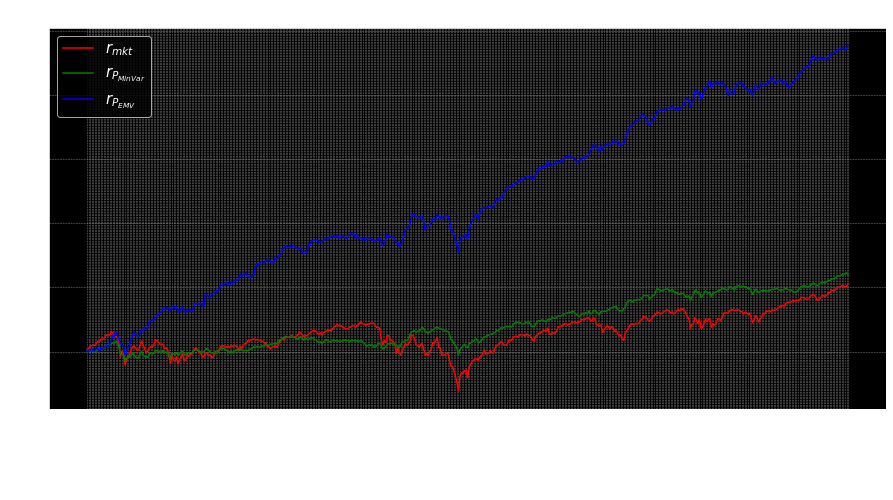

In [25]:
vs.Accum_ts(accum)

##### <font color= 'lightblue'> Metrics: <font>

Confusion Matrix: $\begin{bmatrix} TP & FP \\ FN & TN \end{bmatrix}$

Metrics:

- Accuracy: $\frac{TP + TN}{TP + TN + FP + FN}$ or the ability of the classifier to find + and - samples.

- Precision: $\frac{TP}{TP + FP}$ or the ability of the classifier not to label + samples as -.

- Recall: $\frac{TP}{TP + FN}$ or the ability of the classifier to find all + samples.

- F1 Score: $2 * \frac{Precision * Recall}{Precision + Recall}$ or Precision and Recall equilibrated score through the harmonic mean.    

- ROC AUC: $\frac{TPR}{FPR}$ or the ability of the classifier to find + samples and not - samples. Where a bigger number denotes a better model.

##### <span style='color:lightblue'> Illustrational purposes:
<span style='color:lightyellow'> **Note:** Do not consider the results in this repository or its proceedures as an investment advice or recommendation. <font> 

~ *Past performance is not a guarantee of future results and the market is not always rational.* 

#### <font color= 'gray'>*¿How to reach me?* <font>

[![Website](https://img.shields.io/badge/Website-1f07f5?style=flat-square&logo=google-chrome&logoColor=white)](https://estebanmqz.github.io/Portfolio/)
[![LinkedIn](https://img.shields.io/badge/LinkedIn-173de8?style=flat-square&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/esteban-m-653817205/)
[![E-mail](https://img.shields.io/badge/Business-Mail-083600?style=flat-square&logo=mail&logoColor=white)](mailto:esteban@esteban.com)
[![Github](https://img.shields.io/badge/GitHub-100000?style=flat-square&logo=github&logoColor=white)](https://github.com/EstebanMqz)